In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd

import ray
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib import Policy

import IPython.core.display_functions

from src.parsers import HMParser, CotevParser
from src.resources import Aggregator, Generator, Load, Storage
from src.algorithms.rl import EnergyCommunitySequentialV0, EnergyCommunitySequentialV1
from src.algorithms.rl import EnergyCommunitySequentialV2, EnergyCommunitySequentialV3
from src.algorithms.rl import EnergyCommunitySequentialV8

import warnings
warnings.filterwarnings('ignore')

2024-08-26 16:57:24,348	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
# Data parsing

# EC data for non-renewable generators and batteries
data_ec = HMParser(file_path='/Users/ecgomes/DataspellProjects/pyecom/data/EC_V4.xlsx', ec_id=1)
data_ec.parse()

# EV data from the EV4EU simulator
data_ev = CotevParser(population_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/population_731.csv',
                      driving_history_path=
                      '/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/ev_driving_history_731.csv',
                      assigned_segments_path='/Users/ecgomes/DataspellProjects/pyecom/data/simulation_dataframes_2years/assigned_segments_731.csv',
                      parse_date_start='2019',
                      parse_date_end='2020')
data_ev.parse()

In [3]:
# UPAC Data load

data_upacs = {}
for i in glob.glob('/Users/ecgomes/Documents/PhD/UPAC data/upac*_pv.csv'):
    temp = pd.read_csv(i, index_col=0, parse_dates=True)
    temp = temp.resample('H').mean()
    
    # Need to divide by 1000 to convert from W to kW
    temp['pv'] = temp['pv'] / 1000
    temp['load'] = temp['load'] / 1000
    
    # Set any negative values to zero
    temp.loc[temp['pv'] < 0, 'pv'] = 0
    temp.loc[temp['load'] < 0, 'load'] = 0
    
    # We only want 2019 and 2020 data
    temp = temp.loc['2019':'2020']
    
    # Fill potential NaN values with interpolation
    # temp = temp.interpolate()
    
    # Fill NaN values with zeros
    temp = temp.fillna(0)
    
    name = i.split('/')[-1].split('_')[0].split('upac')[1]
    
    data_upacs[name] = temp

In [4]:
# Train resource creation

def create_resources(upacs, ec, ev):
    """
    Create the resources for the training environment.
    return a list of resources.
    :param upacs: dict with the UPAC data
    :param ec: dict with the EC data
    :param ev: dict with the EV data
    """

    resources = []
    # Add generators (from pv column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Generator(
            name='ren_generator_' + current_name,
            value=np.zeros(upacs[current_name]['pv'].shape),
            lower_bound=np.zeros(upacs[current_name]['pv'].shape),
            upper_bound=upacs[current_name]['pv'].values,
            cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs[current_name].shape[0]),
            cost_nde=np.tile(ec.generator['cost_nde'][0], (int(upacs[current_name].shape[0] / 24))),
            is_renewable=True))

    '''
    resources.append(Generator(
        name='generator_14',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    
    resources.append(Generator(
        name='generator_15',
        value=np.zeros(upacs['02']['pv'].shape),
        lower_bound=np.zeros(upacs['02']['pv'].shape),
        upper_bound=np.ones(upacs['02']['pv'].shape) * 15,
        cost=ec.generator['cost_parameter_b'][0, 0] * np.ones(upacs['02'].shape[0]),
        cost_nde=ec.generator['cost_nde'][0],
        is_renewable=False))
    '''

    # Add loads (from load column from the UPAC data)
    for i in range(len(upacs)):
        current_name = list(upacs.keys())[i]
        resources.append(Load(
            name='load_' + current_name,
            value=upacs[current_name]['load'],
            lower_bound=np.zeros(upacs[current_name].shape),
            upper_bound=upacs[current_name]['load'].values,
            cost=np.ones(upacs[current_name].shape[0]),
            cost_cut=np.tile(ec.load['cost_cut'][0], (int(upacs[current_name].shape[0] / 24))),
            cost_reduce=np.tile(ec.load['cost_reduce'][0], (int(upacs[current_name].shape[0] / 24))),
            cost_ens=np.tile(ec.load['cost_ens'][0], (int(upacs[current_name].shape[0] / 24)))))

    # Add storage (from the EC data)
    for i in range(ec.storage['p_charge_limit'].shape[0]):
        resources.append(Storage(
            name='storage_{:02d}'.format(i+1),
            value=ec.storage['initial_state'][i] * np.ones(upacs['02'].shape[0]),
            lower_bound=np.ones(upacs['02'].shape[0]) * ec.storage['energy_min_percentage'][i],
            upper_bound=(ec.storage['energy_capacity'][i] * np.ones(upacs['02'].shape[0])),
            cost=np.ones(upacs['02'].shape[0]) * 0,
            cost_discharge=np.tile(ec.storage['discharge_price'][i], (int(upacs['02'].shape[0] / 24))),
            cost_charge=np.tile(ec.storage['charge_price'][i], (int(upacs['02'].shape[0] / 24))),
            capacity_max=ec.storage['energy_capacity'][i],
            capacity_min=ec.storage['energy_min_percentage'][i],
            initial_charge=ec.storage['initial_state'][i],
            discharge_efficiency=ec.storage['discharge_efficiency'][i],
            discharge_max=np.tile(ec.storage['p_discharge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            charge_efficiency=ec.storage['charge_efficiency'][i],
            charge_max=np.tile(ec.storage['p_charge_limit'][i], (int(upacs['02'].shape[0] / 24))),
            capital_cost=np.array([0.05250, 0.10500, 0.01575])))

    # Add vehicles (from the EV data)
    for i in np.arange(len(ev)):
        # Append to the list of resources
        # ev[i].cost_charge *= 0
        # ev[i].cost_discharge *= 0
        resources.append(ev[i])

    # Append Aggregator
    resources.append(Aggregator(
        name='aggregator',
        value=np.zeros(upacs['02'].shape[0]),
        lower_bound=np.zeros(upacs['02'].shape[0]),
        upper_bound=np.tile(ec.peers['import_contracted_p_max'][0, 0], (upacs['02'].shape[0])),
        cost=np.tile(ec.peers['buy_price'][0, 0], (upacs['02'].shape[0])),
        imports=np.zeros(upacs['02'].shape[0]),
        exports=np.zeros(upacs['02'].shape[0]),
        import_cost=np.tile(ec.peers['buy_price'][0], (int(upacs['02'].shape[0] / 24))), # * 100,
        export_cost=np.tile(ec.peers['sell_price'][0], (int(upacs['02'].shape[0] / 24))),
        import_max=np.tile(ec.peers['import_contracted_p_max'][0, 0], (int(upacs['02'].shape[0]))),
        export_max=np.tile(ec.peers['export_contracted_p_max'][0, 0], (int(upacs['02'].shape[0])))))

    return resources

In [5]:
# Create resources for the training environment

def iterate_resources(u, c, e, mode='daily'):
    
    temp = {}
    
    # Save first key of upac data
    first_key = list(u.keys())[0]
    
    if mode is 'daily':

        # Loop to iterate over days in the datasets
        for i in np.unique(u[first_key].index.date):
            # Create the resources for the training environment
            
            date = i.strftime('%Y-%m-%d')
            
            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)
            
            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)
            
    elif mode is 'monthly':
        
        # Loop to iterate over months in the datasets
        # Need to be careful with different years
        unique_months = np.unique(data_upacs['02'].index.strftime('%Y-%m'))
        
        for i in unique_months:
            # Create the resources for the training environment
            date = i
            
            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)
            
            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)
            
    elif mode is 'yearly':
        
        # Loop to iterate over years in the datasets
        unique_years = np.unique(data_upacs['02'].index.strftime('%Y'))
        
        for i in unique_years:
            # Create the resources for the training environment
            date = i
            
            temp_u = {k: v.loc[date] for k, v in u.items()}
            temp_e = e.create_resources(e.population, e.trips_grid, e.assigned_segments, date)
            
            temp[date] = create_resources(upacs=temp_u,
                                          ec=c,
                                          ev=temp_e)
        
    return temp

dataset_resources = iterate_resources(u=data_upacs, c=data_ec, e=data_ev, mode='monthly')

In [6]:
# Create the execution order

execution_order = [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][:5]] + \
                  [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][13:-1]] + \
                  [res.name for res in dataset_resources[list(dataset_resources.keys())[0]][10:13]] + \
                  [dataset_resources[list(dataset_resources.keys())[0]][-1].name]
                  #[res.name for res in dataset_resources[list(dataset_resources.keys())[0]][13:-1]]# + \
                  #[res.name for res in dataset_resources[list(dataset_resources.keys())[0]][5:7]]# + \
                  #[dataset_resources[list(dataset_resources.keys())[0]][-1].name]
execution_order

['ren_generator_08',
 'ren_generator_06',
 'ren_generator_02',
 'ren_generator_09',
 'ren_generator_13',
 'ev_01',
 'ev_02',
 'ev_03',
 'ev_04',
 'ev_05',
 'storage_01',
 'storage_02',
 'storage_03',
 'aggregator']

In [7]:
# Create the environment and check if everything is ok

temp_env = EnergyCommunitySequentialV8(ren_generators=dataset_resources[list(dataset_resources.keys())[0]][:5],
                                       generators=[],#dataset_resources[list(dataset_resources.keys())[0]][5:7],
                                       loads=dataset_resources[list(dataset_resources.keys())[0]][5:10],
                                       storages=dataset_resources[list(dataset_resources.keys())[0]][10:13],
                                       evs=dataset_resources[list(dataset_resources.keys())[0]][13:-1],
                                       aggregator=dataset_resources[list(dataset_resources.keys())[0]][-1],
                                       storage_penalty=1,
                                       ev_penalty=1,
                                       balance_penalty=1,
                                       execution_order=execution_order)
temp_env.reset()
terminations = truncations = {a: False for a in temp_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False
while not terminations['__all__'] and not truncations['__all__']:

    actions = temp_env.action_space_sample()
    next_obs, rewards, terminations, truncations, infos = temp_env.step(actions)

print('Terminated: {}'.format(terminations['__all__']))

Terminated: True


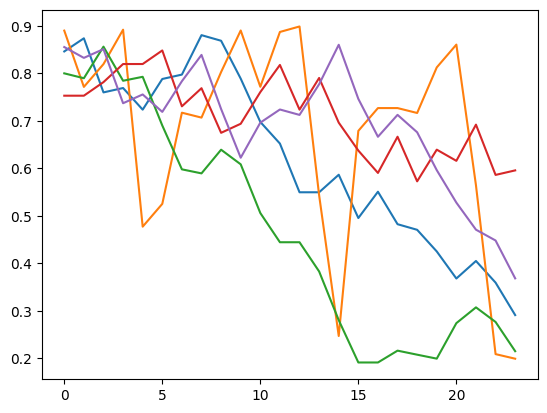

In [8]:
# Plot first 24 points of every EV
for i in temp_env.evs:
    plt.plot(i.value[:24])

In [9]:
temp_env.evs[1].charge

array([1.2150e+00, 0.0000e+00, 6.4800e-01, 9.7830e-01, 0.0000e+00,
       6.4800e-01, 2.5920e+00, 0.0000e+00, 1.2960e+00, 1.1810e+00,
       0.0000e+00, 1.5581e+00, 1.5580e-01, 0.0000e+00, 0.0000e+00,
       5.8320e+00, 6.4800e-01, 0.0000e+00, 0.0000e+00, 1.2960e+00,
       6.4800e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       5.8320e+00, 6.4800e-01, 0.0000e+00, 1.2960e+00, 0.0000e+00,
       4.5360e+00, 0.0000e+00, 4.6051e+00, 4.6050e-01, 4.6100e-02,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 6.4800e-01, 5.1840e+00,
       1.9440e+00, 1.6462e+00, 0.0000e+00, 2.8940e-01, 2.8900e-02,
       2.9000e-03, 0.0000e+00, 7.2030e-01, 0.0000e+00, 0.0000e+00,
       1.9440e+00, 3.8880e+00, 0.0000e+00, 2.0232e+00, 2.0230e-01,
       0.0000e+00, 0.0000e+00, 6.4800e-01, 2.5920e+00, 0.0000e+00,
       0.0000e+00, 2.5920e+00, 0.0000e+00, 0.0000e+00, 2.5920e+00,
       0.0000e+00, 0.0000e+00, 1.2960e+00, 1.2960e+00, 0.0000e+00,
       0.0000e+00, 5.1840e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [10]:
# Create the policies dictionary

def assign_group_policies(env):

    policies = {'generator_renewable': (None,
                              env.observation_space['ren_generator_08'],
                              env.action_space['ren_generator_08'],
                              {}),
                'storage': (None,
                            env.observation_space['storage_01'],
                            env.action_space['storage_01'],
                            {}),
                'ev': (None,
                       env.observation_space['ev_01'],
                       env.action_space['ev_01'],
                       {}),
                #'generator_non_renewable': (None,
                #              env.observation_space['generator_14'],
                #              env.action_space['generator_14'],
                #              {}),
                }

    return policies

def assign_group_policies_v2(env):

    policies = {'ren_08': (None,
                           env.observation_space['ren_generator_08'],
                           env.action_space['ren_generator_08'],
                           {}),
                'ren_09': (None,
                            env.observation_space['ren_generator_09'],
                            env.action_space['ren_generator_09'],
                            {}),
                'ren_02': (None,
                            env.observation_space['ren_generator_02'],
                            env.action_space['ren_generator_02'],
                            {}),
                'ren_06': (None,
                            env.observation_space['ren_generator_06'],
                            env.action_space['ren_generator_06'],
                            {}),
                'ren_13': (None,
                            env.observation_space['ren_generator_13'],
                            env.action_space['ren_generator_13'],
                            {}),
                'storage_01': (None,
                               env.observation_space['storage_01'],
                               env.action_space['storage_01'],
                               {}),
                'storage_02': (None,
                               env.observation_space['storage_02'],
                               env.action_space['storage_02'],
                               {}),
                'storage_03': (None,
                               env.observation_space['storage_03'],
                               env.action_space['storage_03'],
                               {}),
                'ev_01': (None,
                          env.observation_space['ev_01'],
                          env.action_space['ev_01'],
                          {}),
                'ev_02': (None,
                          env.observation_space['ev_02'],
                          env.action_space['ev_02'],
                          {}),
                'ev_03': (None,
                          env.observation_space['ev_03'],
                          env.action_space['ev_03'],
                          {}),
                'ev_04': (None,
                          env.observation_space['ev_04'],
                          env.action_space['ev_04'],
                          {}),
                'ev_05': (None,
                          env.observation_space['ev_05'],
                          env.action_space['ev_05'],
                          {}),
                }

    return policies

def assign_group_policies_v3(env):

    policies = {'ren_08': (None,
                           env.observation_space['ren_generator_08'],
                           env.action_space['ren_generator_08'],
                           {}),
                'ren_09': (None,
                           env.observation_space['ren_generator_09'],
                           env.action_space['ren_generator_09'],
                           {}),
                'ren_02': (None,
                           env.observation_space['ren_generator_02'],
                           env.action_space['ren_generator_02'],
                           {}),
                'ren_06': (None,
                           env.observation_space['ren_generator_06'],
                           env.action_space['ren_generator_06'],
                           {}),
                'ren_13': (None,
                           env.observation_space['ren_generator_13'],
                           env.action_space['ren_generator_13'],
                           {}),
                'storage_01': (None,
                               env.observation_space['storage_01'],
                               env.action_space['storage_01'],
                               {}),
                'storage_02': (None,
                               env.observation_space['storage_02'],
                               env.action_space['storage_02'],
                               {}),
                'storage_03': (None,
                               env.observation_space['storage_03'],
                               env.action_space['storage_03'],
                               {}),
                }
    
    return policies

def assign_group_policies_v4(env):

    policies = {'generator_renewable': (None,
                                        env.observation_space['ren_generator_08'],
                                        env.action_space['ren_generator_08'],
                                        {}),
                'storage_01': (None,
                               env.observation_space['storage_01'],
                               env.action_space['storage_01'],
                               {}),
                'storage_02': (None,
                               env.observation_space['storage_02'],
                               env.action_space['storage_02'],
                               {}),
                'storage_03': (None,
                               env.observation_space['storage_03'],
                               env.action_space['storage_03'],
                               {}),
                }

    return policies

policies = assign_group_policies_v3(env=temp_env)

In [11]:
import logging
# Create an RLlib Algorithm instance from a PPOConfig to learn how to
# act in the above environment.

from ray.tune import register_env
from ray.train import Checkpoint

ray.shutdown()
ray.init()

IMPORT_PENALTY = 1 #100
EXPORT_PENALTY = 1 #10
STORAGE_ACTION_PENALTY = 5 #100
STORAGE_ACTION_REWARD = 5 #10
EV_ACTION_PENALTY = 1 #1000
EV_ACTION_REWARD = 5 #10
EV_REQUIREMENT_PENALTY = 2000 #3000
BALANCE_PENALTY = 5000 #20000

checkpoint = None
checkpoint_path = None
algo = None
current_best = None

# Months per day:
# January: 0:31 -> DONE
# February: 31:59 -> DONE
# March: 59:90 -> DONE
# April: 90:120 -> DONE
# May: 120:151 -> DONE
# June: 151:181 -> DONE
# July: 181:212 -> DONE
# August: 212:243 -> DONE
# September: 243:273 -> DONE
# October: 273:304 -> DONE
# November: 304:334 -> DONE
# December: 334:365 -> DONE

# Build a loop for using separate resources on a daily basis
for datapoint in list(dataset_resources.keys())[:1]:
    
    temp_resources = dataset_resources[datapoint]
    
    env = EnergyCommunitySequentialV8(ren_generators=temp_resources[:5],
                                      generators=[],#temp_resources[5:7],
                                      loads=temp_resources[5:10],
                                      storages=temp_resources[10:13],
                                      evs=temp_resources[13:-1],
                                      aggregator=temp_resources[-1],
                                      storage_penalty=STORAGE_ACTION_PENALTY,
                                      ev_penalty=EV_REQUIREMENT_PENALTY,
                                      balance_penalty=BALANCE_PENALTY,
                                      execution_order=execution_order)

    register_env("EC_Multi", lambda config: env)

    # Define the PPOConfig
    config = PPOConfig() \
        .environment(env="EC_Multi", disable_env_checking=False)\
        .training(train_batch_size=128,
                  lr=2e-4, #tune.grid_search([0.001, 0.0001]),
                  gamma=0.99,
                  use_gae=True,
                  use_critic=True,
                  #model={#'fcnet_activation': 'linear',
                         #'post_fcnet_activation': 'linear',
                         #'use_lstm': True,
                         #'fcnet_hiddens': [64, 64],
                         #'lstm_cell_size': 256,
                         #'max_seq_len': 2,
                         #'lstm_use_prev_action': True,
                         #'lstm_use_prev_reward': True,
                         #'vf_share_layers': True
                  #      }
                )\
        .framework('torch') \
        .rollouts(batch_mode='complete_episodes', #'complete_episodes',
                  num_rollout_workers=1,
                  rollout_fragment_length='auto')\
        .multi_agent(policies={
                               'ren_08': (None,
                                          env.observation_space['ren_generator_08'],
                                          env.action_space['ren_generator_08'],
                                          PPOConfig.overrides(gamma=0.0)),
                               'ren_09': (None,
                                          env.observation_space['ren_generator_09'],
                                          env.action_space['ren_generator_09'],
                                          PPOConfig.overrides(gamma=0.0)),
                               'ren_02': (None,
                                          env.observation_space['ren_generator_02'],
                                          env.action_space['ren_generator_02'],
                                          PPOConfig.overrides(gamma=0.0)),
                               'ren_06': (None,
                                          env.observation_space['ren_generator_06'],
                                          env.action_space['ren_generator_06'],
                                          PPOConfig.overrides(gamma=0.0)),
                               'ren_13': (None,
                                          env.observation_space['ren_generator_13'],
                                          env.action_space['ren_generator_13'],
                                          PPOConfig.overrides(gamma=0.0)),
                               'ev_01': (None,
                                         env.observation_space['ev_01'],
                                         env.action_space['ev_01'],
                                         PPOConfig.overrides(gamma=0.9)),
                               'ev_02': (None,
                                         env.observation_space['ev_02'],
                                         env.action_space['ev_02'],
                                         PPOConfig.overrides(gamma=0.9)),
                               'ev_03': (None,
                                         env.observation_space['ev_03'],
                                         env.action_space['ev_03'],
                                         PPOConfig.overrides(gamma=0.9)),
                               'ev_04': (None,
                                         env.observation_space['ev_04'],
                                         env.action_space['ev_04'],
                                         PPOConfig.overrides(gamma=0.9)),
                               'ev_05': (None,
                                         env.observation_space['ev_05'],
                                         env.action_space['ev_05'],
                                         PPOConfig.overrides(gamma=0.9)),
                               'storage_01': (None,
                                              env.observation_space['storage_01'],
                                              env.action_space['storage_01'],
                                              PPOConfig.overrides(gamma=0.9)),
                               'storage_02': (None,
                                              env.observation_space['storage_02'],
                                              env.action_space['storage_02'],
                                              PPOConfig.overrides(gamma=0.9)),
                               'storage_03': (None,
                                              env.observation_space['storage_03'],
                                              env.action_space['storage_03'],
                                              PPOConfig.overrides(gamma=0.9)),
                               'aggregator': (None,
                                              env.observation_space['aggregator'],
                                              env.action_space['aggregator'],
                                              PPOConfig.overrides(gamma=0.9))},
                     policy_mapping_fn=(
                         lambda agent_id, episode, worker, **kwargs:
                                        #'generator_renewable' if agent_id.startswith('ren_generator') else
                                        'ren_08' if agent_id.startswith('ren_generator_08') else
                                        'ren_09' if agent_id.startswith('ren_generator_09') else
                                        'ren_02' if agent_id.startswith('ren_generator_02') else
                                        'ren_06' if agent_id.startswith('ren_generator_06') else
                                        'ren_13' if agent_id.startswith('ren_generator_13') else
                                        'storage_01' if agent_id.startswith('storage_01') else
                                        'storage_02' if agent_id.startswith('storage_02') else
                                        'storage_03' if agent_id.startswith('storage_03') else
                                        'ev_01' if agent_id.startswith('ev_01') else
                                        'ev_02' if agent_id.startswith('ev_02') else
                                        'ev_03' if agent_id.startswith('ev_03') else
                                        'ev_04' if agent_id.startswith('ev_04') else
                                        'ev_05' if agent_id.startswith('ev_05') else
                                        'aggregator'
                                        ))
    
    # if agent_id.startswith('ev') else
                                        #'generator_non_renewable'))

    #results = tune.run(
    #    "PPO",
    #    stop={"training_iteration": 100},
    #    config=config.to_dict(),
    #    checkpoint_at_end=True,
    #    verbose=0,
    #)
    algo = config.build()
    
    '''
    # Load the checkpoint if it exists
    if checkpoint is not None:
        policy = Policy.from_checkpoint(checkpoint.checkpoint.path)
    
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    elif checkpoint_path is not None:
        checkpoint = Checkpoint.from_directory(checkpoint_path)
        policy = Policy.from_checkpoint(checkpoint)
    
        for p in policies.keys():
            if p in policy.keys():
                algo.get_policy(p).set_weights(policy[p].get_weights())
    '''
    
    
    # Clear the Jupyter cell output
    IPython.core.display_functions.clear_output()
    
    # Train for n iterations and report results (mean episode rewards)
    print(f"Datapoint {datapoint}\n")
    for i in range(200):
        results = algo.train()
        print(f"Iter: {i}; avg. reward={results['episode_reward_mean']}")
        # print(f"Policy rewards: {results['policy_reward_mean']}")
        # if results['episode_reward_mean'] > 500:
        #     break
        # if results['episode_reward_mean'] > current_best_results['episode_reward_mean']:
        #     current_best = algo.save()
        #     current_best_results = results



# if results['episode_reward_mean'] < 500:
        # Save the checkpoint to disk.
        # checkpoint = algo.save()
        # algo.save('/Users/ecgomes/DataspellProjects/pyecom/models/sequential_v6_nogen_fullpenalty_{}'.format(datapoint))
        
    # else:
    #    break
    # print("checkpoints saved at", checkpoint)

Datapoint 2019-01


(RolloutWorker pid=14328) 2024-08-26 16:58:25,578	WARNING env_runner_v2.py:155 -- More than 10416 observations in 10416 env steps for episode 13389963565255762 are buffered in the sampler. If this is more than you expected, check that that you set a horizon on your environment correctly and that it terminates at some point. Note: In multi-agent environments, `rollout_fragment_length` sets the batch size based on (across-agents) environment steps, not the steps of individual agents, which can result in unexpectedly large batches.Also, you may be waiting for your Env to terminate (batch_mode=`complete_episodes`). Make sure it does at some point.


Iter: 0; avg. reward=-378764.7666999996
Iter: 1; avg. reward=-256776.28749999963
Iter: 2; avg. reward=-193199.67879999964
Iter: 3; avg. reward=-153372.75609999968
Iter: 4; avg. reward=-128147.2895799997
Iter: 5; avg. reward=-112190.04464999969
Iter: 6; avg. reward=-99540.96729999979
Iter: 7; avg. reward=-89046.03997499985
Iter: 8; avg. reward=-83135.86491111081
Iter: 9; avg. reward=-76762.66716999972
Iter: 10; avg. reward=-70760.37819090889
Iter: 11; avg. reward=-66191.46374999986
Iter: 12; avg. reward=-62459.36873846139
Iter: 13; avg. reward=-59166.17141428561
Iter: 14; avg. reward=-56764.42033999989
Iter: 15; avg. reward=-54382.90735624987
Iter: 16; avg. reward=-52590.84650588215
Iter: 17; avg. reward=-50396.321555555434
Iter: 18; avg. reward=-48398.9639526315
Iter: 19; avg. reward=-46525.40085999995
Iter: 20; avg. reward=-44693.78943333334
Iter: 21; avg. reward=-43534.87229545447
Iter: 22; avg. reward=-42298.38303043476
Iter: 23; avg. reward=-41379.84812916654
Iter: 24; avg. reward=

KeyboardInterrupt: 

In [10]:
algo.save('/Users/ecgomes/DataspellProjects/pyecom/models/no_costs/sequential_monthly_noev_v1')

TrainingResult(checkpoint=Checkpoint(filesystem=local, path=/Users/ecgomes/DataspellProjects/pyecom/models/no_costs/sequential_monthly_noev_v1), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'__all__': {'num_agent_steps_trained': 1152.0, 'num_env_steps_trained': 744.0, 'total_loss': 3.2134428586278645}, 'ren_08': {'total_loss': 3.2134428586278645, 'policy_loss': 0.0003935329509632928, 'vf_loss': 3.8432056348775796e-08, 'vf_loss_unclipped': 3.8432056348775796e-08, 'vf_explained_var': -1.0, 'entropy': 0.00032196849027449, 'mean_kl_loss': -1.635482569543432e-08, 'default_optimizer_lr': 0.0002, 'curr_lr': 0.0002, 'curr_entropy_coeff': 0.0, 'curr_kl_coeff': 0.0}, 'ren_06': {'total_loss': -0.00019010848232678005, 'policy_loss': -0.00019013179200036185, 'vf_loss': 2.6834569862696105e-08, 'vf_loss_unclipped': 2.6834569862696105e-08, 'vf_explained_var': -1.0, 'entropy': 0.00014740432080413614, 'mean_kl_loss': 2.3265230955043277e-09, 'default_optimizer_lr': 0.0002, 'cu

In [11]:
dataset_resources[list(dataset_resources.keys())[0]][-2].discharge_efficiency #*\
# dataset_resources[list(dataset_resources.keys())[0]][-2].schedule_requirement_soc

0.9

In [ ]:
# Check the results
# Create a new env

test_resources = dataset_resources[list(dataset_resources.keys())[0]]

test_env = EnergyCommunitySequentialV0(ren_generators=test_resources[:5],
                                       generators=test_resources[5:7],
                                       loads=test_resources[7:12],
                                       storages=test_resources[12:15],
                                       evs=test_resources[15:-1],
                                       aggregator=test_resources[-1],
                                       ev_penalty=1,
                                       balance_penalty=BALANCE_PENALTY,
                                       execution_order=execution_order)

obs, info = test_env.reset()

# Set up the terminations and truncations
terminations = truncations = {a: False for a in test_env.agents}
terminations['__all__'] = False
truncations['__all__'] = False

while not terminations['__all__'] and not truncations['__all__']:

    current_agent = test_env.execution_order[test_env._current_agent_idx]

    current_policy = 'generator_renewable' if current_agent.startswith('ren_gen') else \
        'storage' if current_agent.startswith('storage') else \
            'ev' if current_agent.startswith('ev') else \
                'generator_non_renewable'

    action_dict = {current_agent: algo.compute_single_action(observation=obs[current_agent],
                                                             policy_id=current_policy)}

    obs, rewards, terminations, truncations, info = test_env.step(action_dict)

In [ ]:
# Plot the generator power output

plt.figure()

for i in range(5):
    plt.plot(test_env.ren_generators[i].value)

plt.legend(['generator_{:02d}'.format(i+1) for i in range(data_ec.generator['p_forecast'].shape[0])])
plt.show()

In [ ]:
# Create subplots with the generator values and the forecast

fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i in np.arange(5):
    axs[i].plot(test_env.ren_generators[i].value, label='rl_{:02d}'.format(i+1))
    axs[i].plot(data_upacs[list(data_upacs.keys())[i]]['pv'].loc['2019-01-01'].values, label='forecast_{:02d}'.format(i+1),
                linestyle='--')
    
    axs[i].legend()
    
plt.show()

In [ ]:
# Plot the storage state of charge

plt.figure()

for i in range(data_ec.storage['p_charge_limit'].shape[0]):
    plt.plot(test_env.storages[i].value * test_env.storages[i].capacity_max)
    
plt.yticks(np.arange(0, 120, 10))

plt.legend(['storage_{:02d}'.format(i+1) for i in range(data_ec.storage['p_charge_limit'].shape[0])])
plt.show()

In [ ]:
# Plot the load values

plt.figure()

for i in range(5):
    plt.plot(test_env.loads[i].value)
    
plt.legend(['load_{:02d}'.format(i+1) for i in range(5)])
plt.show()

In [ ]:
# Check imports and exports

plt.figure()

plt.plot(test_env.aggregator.imports, label='imports')
plt.plot(test_env.aggregator.exports, label='exports')

plt.legend()
plt.show()

In [ ]:
# Check EVs

plt.figure()

for ev in test_env.evs:
    plt.plot(ev.value * ev.capacity_max, label=ev.name)

plt.yticks(np.arange(0, 80, 5))
plt.legend()

plt.show()

In [ ]:
for ev in test_env.evs:
    print(ev.name)
    print(ev.charge)

In [ ]:
for i in range(len(test_env.evs)):
    plt.plot(test_env.evs[i].schedule_requirement_soc)

In [ ]:
# Check the sum of values

test_prod = pd.DataFrame({'ren_gen': np.sum([test_env.ren_generators[i].value for i in range(5)], axis=0),
                          'sdischarge': np.sum([test_env.storages[i].discharge for i in range(3)], axis=0),
                          'evdischarge': np.sum([test_env.evs[i].discharge for i in range(5)], axis=0),
                          'non_ren_gen': np.sum([test_env.generators[i].value for i in range(2)], axis=0),
                          'imports': test_env.aggregator.imports})

test_cons = pd.DataFrame({'loads': np.sum([test_env.loads[i].value for i in range(5)], axis=0),
                          'scharge': np.sum([test_env.storages[i].charge / test_env.storages[i].charge_efficiency 
                                             for i in range(3)], axis=0),
                          'evcharge': np.sum([test_env.evs[i].charge / test_env.evs[i].charge_efficiency 
                                              for i in range(5)], axis=0),
                          'exports': test_env.aggregator.exports})

fig, axs = plt.subplots(3, 1, figsize=(10, 10))

test_prod.plot(kind='area', ax=axs[0])
test_cons.plot(kind='area', ax=axs[1])

axs[2].plot(test_prod.sum(axis=1)[0:], label='prod')
axs[2].plot(test_cons.sum(axis=1)[0:], label='cons')

plt.legend()
plt.show()

In [ ]:
test_prod

In [ ]:
test_cons

In [ ]:
test_env.aggregator.imports